In [50]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os
from pprint import pprint

import pickle

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS

import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

In [1]:
! curl -u $semblables:$kantishnatokusadasi1491 -XDELETE https://api.github.com/repos/python-practice-with-datatypes-data-science-intro-000

{
  "message": "Not Found",
  "documentation_url": "https://docs.github.com/rest"
}


In [51]:
survey = pd.read_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/surveydata.csv')
latlon = pd.read_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/latlon.csv')
convo = pd.read_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/convos.csv')

# This line can only be run once, or it will produce NaN
survey.uid = survey.uid.str.split('u').str.get(1).astype(int)

In [52]:
data = survey.merge(latlon, on='uid', how='outer')
data = data.merge(convo, on='uid', how='outer')

In [53]:
try:
    data = data[~(data.uid==0)].drop(columns=['10x_per_day']).dropna()
except:
    print('Data already dropped')
    
if data.isnull().sum().sum() == 0:
    print('No more missing values.')

No more missing values.


In [54]:
len(data)

1152

In [55]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/education/grades.csv'
grades = pd.read_csv(path)
grades.uid = grades.uid.str.extract('(\d\d)').astype(int)
len(grades)
grades = data.merge(grades, on='uid', how='inner').dropna()
len(grades)

686

In [68]:
grades = pd.read_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/education/grades.csv')
grades.uid = grades.uid.str.split('u').str.get(1).astype(int)
grades = data.merge(grades, on='uid', how='inner').dropna()
grades.columns = grades.columns.str.strip()

# Dropping questions by slicing df twice and then concatenating
slice_1 = grades.iloc[:, :2]
slice_2 = grades.iloc[:, 47:]
grades = pd.concat([slice_1, slice_2],
                   axis=1)

# Replacing spaces with underscores
grades.columns = grades.columns.str.replace(' ', '_')

# Showing all columns currently in df with index
grades.columns

# Renaming 'loneliness_average_y'
grades.rename(
    {'loneliness_average_y': 'loneliness_average'},
    axis=1,
    inplace=True
)

In [69]:
# Reducing again to relevant features
grades_full = grades.copy()

grades = grades[[
    'loneliness_average', 'stress_average', 'depression_average',
    'overnight_primary_bld', 'daytime_primary_bld', 'avg_length',
    'num', 'kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4', 'gpa_all', 'uid'
]]

In [70]:
# Selecting categorical variables to create dummy variables for
categorical_vars = ['overnight_primary_bld', 'daytime_primary_bld']

# Generating and concatenating dummy variables with for lopp
for var in categorical_vars:
    dummies = pd.get_dummies(grades[var])
    # Editing variable names to contain mother variable and the category (building)
    dummies.columns = [var+str(col) for col in dummies.columns]
    grades = pd.concat([grades, dummies],axis=1)

3.401760932944612


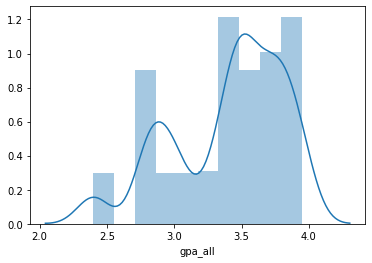

In [71]:
sns.distplot(grades.gpa_all)
print(grades.gpa_all.mean())

In [72]:
len(grades[grades.gpa_all < 3.4]) / len(grades)

0.3760932944606414

In [73]:
X = grades[[
 'kmeans0',
 'kmeans1'
]]

y_gpa = grades.gpa_all
y_depression = grades.depression_average
y_stress = grades.stress_average
y_loneliness = grades.loneliness_average

gpa_X_train, gpa_X_test, gpa_y_train, gpa_y_test = train_test_split(
    X, y_gpa, train_size=.7
)

dpr_X_train, dpr_X_test, dpr_y_train, dpr_y_test = train_test_split(
    X, y_depression, train_size=.7
)

str_X_train, str_X_test, str_y_train, str_y_test = train_test_split(
    X, y_stress, train_size=.7
)

lln_X_train, lln_X_test, lln_y_train, lln_y_test = train_test_split(
    X, y_loneliness, train_size=.7
)

0.9894166682516597
{'max_depth': 13, 'max_leaf_nodes': 25, 'n_estimators': 40}


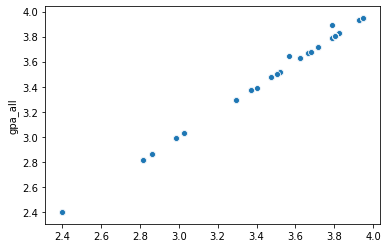

In [74]:
gpa_rfr = RandomForestRegressor(random_state=42)
gpa_params = {'n_estimators': [40],
              'max_depth': [13],
              'max_leaf_nodes': [25]}
gpa_gscv = GridSearchCV(gpa_rfr, gpa_params, cv=5)
gpa_gscv.fit(gpa_X_train, gpa_y_train) # Why do these need to be split?
preds = gpa_gscv.predict(gpa_X_test)
print(gpa_gscv.best_score_)
print(gpa_gscv.best_params_)
sns.scatterplot(
    x=preds,
    y=gpa_y_test
)

In [75]:
pred = gpa_gscv.predict(np.array([600, 2000]).reshape(1, -1))
pred

array([2.94185])

# Generating Models

*Return to tune models.*

In [76]:
def generate_gridsearch(X, y, params):
    
    X_train, X_test, y_train, y_test = train_test_split(
         X,
         y,
         train_size=.7,
         random_state=42
    )
    
    rfr = RandomForestRegressor(random_state=42)
    gscv = GridSearchCV(rfr, params, cv=5)
    gscv.fit(X_train, y_train)
    preds = gscv.predict(X_test)
    
    errors = preds - y_test
    
    print('Mean error %: ', abs(errors).mean())
    print('Mean error raw: ', abs(errors).mean() * 4)
    print('Best score: ', gscv.best_score_)
    print('Best params: ', gscv.best_params_)
    sns.scatterplot(
        x=preds,
        y=y_test
    )
    plt.plot()
    
    return gscv.best_estimator_

**Predicting GPA with K-Means Conversation Clusters**

Mean error %:  0.0019782336360803323
Mean error raw:  0.00791293454432133
Best score:  0.991731760729926
Best params:  {'max_depth': 9, 'n_estimators': 31}


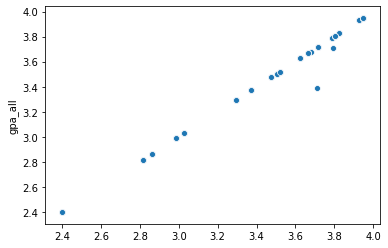

In [77]:
params = {'n_estimators': [31],
          'max_depth': [9]}
kmeans_gpa_model = generate_gridsearch(
    grades[['kmeans0', 'kmeans1', 'kmeans2',
     'kmeans3', 'kmeans4']],
    grades.gpa_all,
    params
)

**Predicting GPA with Raw Conversation Data**

Mean error %:  0.004822006472492241
Mean error raw:  0.019288025889968963
Best score:  0.9832875475320485
Best params:  {'max_depth': 10, 'n_estimators': 3}


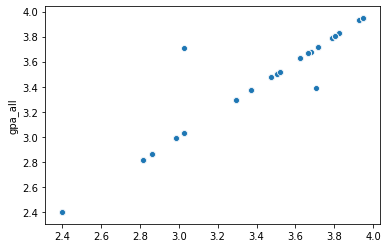

In [17]:
params = {'n_estimators': [3],
          'max_depth': [10]}
raw_convo_gpa_model = generate_gridsearch(
    grades[['num', 'avg_length']],
    grades.gpa_all,
    params
)

**Predicting GPA with Primary Overnight Cluster**

Mean error %:  0.17985616967246823
Mean error raw:  0.7194246786898729
Best score:  0.39756521911061876
Best params:  {'max_depth': 16, 'n_estimators': 80}


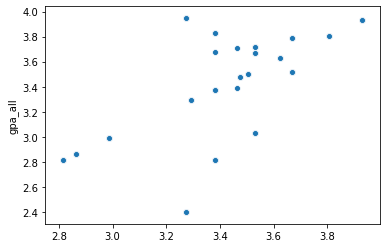

In [18]:
overnight_pri_X_vars = ['overnight_primary_bldalpha_theta',
    'overnight_primary_bldchanning_cox_hall', 'overnight_primary_bldchinese_house',
    'overnight_primary_bldchoate_cluster', 'overnight_primary_bldcomputer_science_dept',
    'overnight_primary_bldeast_wheelock_house', 'overnight_primary_bldepsilon_kappa_theta',
    'overnight_primary_bldfayerweather_hall', 'overnight_primary_bldfrench/judge_hall',
    'overnight_primary_bldgreek_webster_ave', 'overnight_primary_bldhouse_center_b',
    'overnight_primary_bldmclaughlin_cluster', 'overnight_primary_bldnative_american_house',
    'overnight_primary_bldnorth_park_house', 'overnight_primary_bldphi_tau',
    'overnight_primary_bldschool_house', 'overnight_primary_bldsouth_house',
    'overnight_primary_bldwest_house', 'overnight_primary_bldwheeler_hall']

params = {'n_estimators': [80],
          'max_depth': [16]}
overnight_pri_gpa_model = generate_gridsearch(
    grades[overnight_pri_X_vars],
    grades.gpa_all,
    params
)

**Predicting GPA with Primary Daytime Clusters**

Mean error %:  0.0842826416663629
Mean error raw:  0.3371305666654516
Best score:  0.8272888011184502
Best params:  {'max_depth': 16, 'n_estimators': 90}


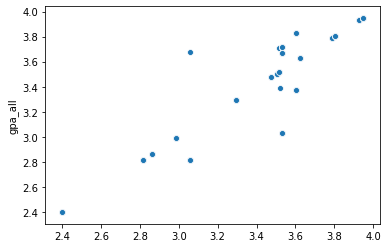

In [19]:
daytime_pri_X_vars = [
    'daytime_primary_bldarts_center', 'daytime_primary_bldberry_library',
       'daytime_primary_bldcollis_center',
       'daytime_primary_bldcomputer_science_dept',
       'daytime_primary_bldeast_hanover',
       'daytime_primary_bldeast_wheelock_house',
       'daytime_primary_bldfayerweather_hall',
       'daytime_primary_bldgreek_webster_ave',
       'daytime_primary_bldmaxwell_hall',
       'daytime_primary_bldmclaughlin_cluster',
       'daytime_primary_bldnorth_park_house', 'daytime_primary_bldphi_tau',
       'daytime_primary_bldschool_house',
       'daytime_primary_bldsigma_alpha_epsilon',
       'daytime_primary_bldtriangle_house', 'daytime_primary_bldwest_house'
]

primary_latlon_cluster_X_vars = overnight_pri_X_vars + daytime_pri_X_vars

params = {'n_estimators': [90],
          'max_depth': list(range(2, 40, 2))}
primary_latlon_cluster_gpa_model = generate_gridsearch(
    grades[primary_latlon_cluster_X_vars],
    grades.gpa_all,
    params
)

**Predicting GPA with All Lat-lon Clusters**

In [20]:
latlon_X = pd.get_dummies(grades_full[['overnight_secondary_bld', 'overnight_secondary_type',
       'daytime_primary_bld', 'daytime_primary_type', 'daytime_secondary_bld',
       'daytime_secondary_type', 'daytime_tertiary_bld',
       'daytime_tertiary_type', 'overnight_primary_cluster',
       'overnight_secondary_cluster', 'daytime_primary_cluster',
       'daytime_secondary_cluster', 'daytime_tertiary_cluster']])

In [45]:
params = {'n_estimators': [114],
          'max_depth': [17]}

latlon_gpa_model = generate_gridsearch(
    latlon_X,
    grades.gpa_all,
    params
)

AttributeError: 'DataFrame' object has no attribute 'gpa_all'

**Predicting Depression with All Lat-lon Clusters**

In [22]:
post_latlon_X = pd.get_dummies(
    grades_full.loc[grades_full.type=='post',
        ['overnight_secondary_bld', 'overnight_secondary_type',
       'daytime_primary_bld', 'daytime_primary_type', 'daytime_secondary_bld',
       'daytime_secondary_type', 'daytime_tertiary_bld',
       'daytime_tertiary_type', 'overnight_primary_cluster',
       'overnight_secondary_cluster', 'daytime_primary_cluster',
       'daytime_secondary_cluster', 'daytime_tertiary_cluster']
                   ]
)

In [23]:
params = {'n_estimators': [193],
          'max_depth': [17]}

post_latlon_depr_model = generate_gridsearch(
    post_latlon_X,
    grades.loc[grades.type=='post', 'depression_average'],
    params
)

AttributeError: 'DataFrame' object has no attribute 'type'

**Predicting Stress with All Lat-lon Clusters**

In [ ]:
params = {'n_estimators': [170],
          'max_depth': [4]}

post_latlon_stress_model = generate_gridsearch(
    post_latlon_X,
    grades.loc[grades.type=='post', 'stress_average'],
    params
)

**Predicting Loneliness with All Lat-lon Clusters**

In [ ]:
params = {'n_estimators': [158],
          'max_depth': [10]}

post_latlon_loneliness_model = generate_gridsearch(
    post_latlon_X,
    grades.loc[grades.type=='post', 'loneliness_average'],
    params
)

In [ ]:
grades['type'] = grades_full.type

pre_survey_X = grades.loc[
    grades.type=='pre',
    ['loneliness_average', 'stress_average', 'depression_average']
]

params = {'n_estimators': [132],
          'max_depth': [13]}
survey_gpa_model = generate_gridsearch(
    pre_survey_X,
    grades.loc[grades.type=='pre', 'gpa_all'],
    params
)

# Creating Dash Web App

In [ ]:
pickle.dump(raw_convo_gpa_model, open("raw_convo_gpa_model.py", "wb"))

file = open("raw_convo_gpa_model.py", 'rb')
rfr_pickle = pickle.load(file)

rfr_pickle.score(
    grades[['num', 'avg_length']], grades.gpa_all)

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

diff = max(grades.num) - min(grades.num)
marks_spacing = range(min(grades.num), max(grades.num), int(diff/10))

fig = px.scatter(grades, x='uid', y='gpa_all')

# fig.update_layout(
#     plot_bgcolor=colors['background'],
#     paper_bgcolor=colors['background'],
#     font_color=colors['text']
# )

app.layout = html.Div([
    
    dcc.Graph(id='graph-with-slider'),
    
    dcc.Slider(
        id='length--slider',
        min=grades.num.min(),
        max=grades.num.max(),
        value=grades.num.min(),
        marks={marks_space:marks_space for marks_space in marks_spacing},
        step=None
    ),
    
    html.H1("Simple input example"),
    html.Div(id='result')
    ])


@app.callback(
    Output('result', 'children'),
    [Input('input-x', 'value'),
     Input('input-y', 'value')]
) 

def update_result(x, y):
    return "The sum is: {}".format(x + y)

@app.callback(
    Output('graph-with-slider', 'figure'),
    [Input('num-slider', 'value')])

def update_figure(selected_num):
    filtered_df = grades[(grades.num > selected_num - 330) &
                         (grades.num < selected_num + 330)]

    fig = px.scatter(filtered_df,
                     x="avg_length",
                     y="gpa_all", 
#                      size="pop",
                     color='uid',
                     hover_name="gpa_all", 
                     range_x=[min(grades.avg_length) - 10, max(grades.avg_length) + 10],
                     range_y=[min(grades.gpa_all) - .1, max(grades.gpa_all) + .1],
                     log_x=False,
                     size_max=55)

    fig.update_layout(transition_duration=500)

    return fig

@app.callback(
    Output('my-output-num', 'value'),
    [Input('num-slider', 'value')])

def update_pred(selected_num):
    pred = rfr_pickle.predict(np.array([selected_num, 675.5922998]).reshape(1, -1))
    return pred

if __name__ == '__main__':
    app.run_server(mode='inline',
                   debug=False)